In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tqdm
from math import sqrt

In [ ]:
learning_rate = 1e-3
num_epochs = 10
batch_size = 8
beta = 0.001

In [ ]:
data_path = './data'
device = 'cuda:0'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True, generator=torch.Generator(device=device))
loader_test = DataLoader(test_dat, batch_size, shuffle=False, generator=torch.Generator(device=device))

In [ ]:

def make_time_embedding(num_steps, emb_dim):
    embedding_mat = torch.empty((num_steps, emb_dim))
    for step in range(num_steps):
        embedding = torch.tensor([1 / 10000 ** (2*i / emb_dim) for i in range(emb_dim)])
        if step % 2 == 0:
            embedding = (embedding * step).sin()
        else:
            embedding = (embedding * step).cos()
        embedding_mat[step] = embedding
    time_embed = nn.Embedding(num_steps, emb_dim)
    time_embed.weight.data = embedding_mat
    time_embed.requires_grad_(False)
    return time_embed


In [ ]:

def make_time_embedding_mlp(in_d, out_d):
    return nn.Sequential(
        nn.Linear(in_d, out_d),
        nn.ReLU(),
        nn.Linear(out_d, out_d)
    )
        

class Block(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, normalize=True):
        super(Block, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU()
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out
    

class UNet(nn.Module):
    """ Using a UNet architecture as noise function approximator """
    def __init__(self, num_steps=1000, emb_dim=100):
        super(UNet, self).__init__()
        self.time_embed = make_time_embedding(num_steps, emb_dim)
        self.te1 = make_time_embedding_mlp(emb_dim, 1)
        self.b1 = nn.Sequential(
            Block((1, 28, 28), 1, 10),
            Block((10, 28, 28), 10, 10),
            Block((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = make_time_embedding_mlp(emb_dim, 10)
        self.b2 = nn.Sequential(
            Block((10, 14, 14), 10, 20),
            Block((20, 14, 14), 20, 20),
            Block((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = make_time_embedding_mlp(emb_dim, 20)
        self.b3 = nn.Sequential(
            Block((20, 7, 7), 20, 40),
            Block((40, 7, 7), 40, 40),
            Block((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = make_time_embedding_mlp(emb_dim, 40)
        self.b_mid = nn.Sequential(
            Block((40, 3, 3), 40, 20),
            Block((20, 3, 3), 20, 20),
            Block((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = make_time_embedding_mlp(emb_dim, 80)
        self.b4 = nn.Sequential(
            Block((80, 7, 7), 80, 40),
            Block((40, 7, 7), 40, 20),
            Block((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = make_time_embedding_mlp(emb_dim, 40)
        self.b5 = nn.Sequential(
            Block((40, 14, 14), 40, 20),
            Block((20, 14, 14), 20, 10),
            Block((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = make_time_embedding_mlp(emb_dim, 20)
        self.b_out = nn.Sequential(
            Block((20, 28, 28), 20, 10),
            Block((10, 28, 28), 10, 10),
            Block((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)
    
    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)
        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)
        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)
        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)
        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)
        out = self.conv_out(out)
        return out





In [ ]:

def calc_xt(epsilon, beta, t, x0):
    """ Note: this assumes beta doesn't vary with time step """
    at = (1 - beta) ** t
    # print(f'at: {at.shape} x0: {x0.shape} epsilon: {epsilon.shape}')
    return torch.sqrt(at.view(batch_size,1,1,1)) * x0 + torch.sqrt(1 - at.view(batch_size,1,1,1)) * epsilon

def sample_t(batch_size, timesteps):
    return torch.randint(1, timesteps+1, (batch_size,))

def sample_epsilon(batch_size, img_h, img_w):
    return torch.normal(torch.zeros((batch_size, 1, img_h, img_w)), torch.ones((batch_size, 1, img_h, img_w)))

def calc_loss(epsilon, epsilon_pred):
    return torch.linalg.vector_norm(epsilon - epsilon_pred)


In [ ]:
timesteps = 1000
img_w = 28
img_h = 28

torch.set_default_device(device)
model = UNet(num_steps=timesteps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

In [ ]:

train_loss, test_loss = [], []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_test_loss = 0
    if epoch > 1:
        break 

    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            data = data.to(device)
            epsilon = sample_epsilon(batch_size, img_h, img_w)
            t = sample_t(batch_size, timesteps)
            xt = calc_xt(epsilon, beta, t, data)
            epsilon_pred = model(xt, t)
            loss = calc_loss(epsilon, epsilon_pred)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_train_loss += loss.item()
            if batch_idx % 20 == 0:
                tepoch.set_description(f"Train Epoch {epoch}")
                tepoch.set_postfix(loss=epoch_train_loss/((batch_idx+1) * batch_size))
        print(f'Train Loss: {epoch_train_loss / (len(tepoch) * batch_size)}')
        train_loss.append(epoch_train_loss / (len(tepoch) * batch_size))

        with tqdm.tqdm(loader_test, unit="batch") as tepoch:
            for batch_idx, (data, _) in enumerate(tepoch):
                data = data.to(device)
                with torch.no_grad():
                    epsilon = sample_epsilon(batch_size, img_h, img_w)
                    t = sample_t(batch_size, timesteps)
                    xt = calc_xt(epsilon, beta, t, data)
                    epsilon_pred = model(xt, t)
                    loss = calc_loss(epsilon, epsilon_pred)
                    epoch_test_loss += loss.item()
            print(f'Test Loss: {epoch_test_loss / (len(tepoch) * batch_size)}')
            test_loss.append(epoch_test_loss / (len(tepoch) * batch_size))
        

In [ ]:
x1 = torch.tensor([3,3,3])
x2 = torch.tensor([2,2,2])
print((x1+1) ** x2)

In [ ]:
x1 = torch.tensor([1,2,3,4])
x2 = torch.tensor([[3,3],[3,3],[3,3],[3,3]])
print(x1.shape)
print(x2.shape)
x3 = x1.view((4,1)) * x2
print(x3)

std: torch.Size([8, 1, 28, 28]) mean: torch.Size([8, 1, 28, 28])


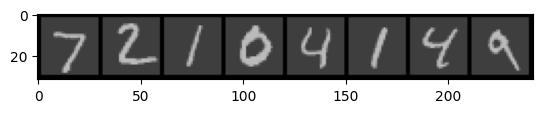

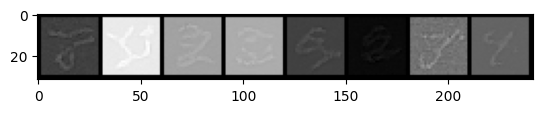

In [25]:
import torch
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
from math import sqrt

from unet import UNet

def denorm(x, channels=None, w=None ,h=None, resize = False):
    mean = torch.Tensor([0.4914])
    std = torch.Tensor([0.247])
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


def sample_diffusion_model(model, timesteps, min_beta, max_beta, batch_size, xt=None):
    # sigma_t = sqrt(beta)
    if xt == None:
        xt = torch.normal(torch.zeros((batch_size,1,28,28)), torch.ones((batch_size,1,28,28)))
    for t in range(timesteps,0,-1):
        cur_beta = calc_beta(min_beta, max_beta, t, timesteps)
        # print(f'beta: {cur_beta}')
        # cur_beta = torch.ones((batch_size))
        # for i in range(batch_size):
        #     cur_beta = calc_beta(min_beta, max_beta, t, timesteps)
        sigma_t = sqrt(cur_beta)
        at = 1 - cur_beta
        at_hat = 1
        for s in range(1,t+1):
            at_hat *= (1 - calc_beta(min_beta, max_beta, s, timesteps))
        # at_hat = (1 - cur_beta) ** t
        # at_hat = torch.ones((batch_size,))
        # for i in range(batch_size):
        #     for j in range(t):
        #         at_hat[i] *= (1 - calc_beta(min_beta, max_beta, j, timesteps))

        z = torch.normal(torch.zeros((batch_size,1,28,28)), torch.ones((batch_size,1,28,28)))
        if t == 1:
            z = torch.zeros((batch_size,1,28,28))
        epsilon_pred = model(xt,torch.full((batch_size,),t))
        xt = (xt - epsilon_pred*(1-at)/sqrt(1-at_hat)) / sqrt(at) + sigma_t*z
        # if t % 100 == 0 or t == 1:
        if t == 1:
            xt_ = xt
            # TODO: trying to solve xt_ way bigger than range 0-1
            # xt_ -= xt_.min(1, keepdim=True)[0]
            # xt_ /= xt_.max(1, keepdim=True)[0]
            min_val = xt_.min()
            max_val = xt_.max()
            xt_ = (xt_ - min_val) / (max_val - min_val)
            # xt_ = denorm(xt_)
            
            xt_ = make_grid(xt_, nrow=8, padding=2, normalize=False,
                                value_range=None, scale_each=False, pad_value=0)
            # xt_ = make_grid(denorm(xt_), nrow=8, padding=2, normalize=False,
            #                     value_range=None, scale_each=False, pad_value=0)
            plt.figure()
            show(xt_)
    return xt


def encode_img(x0, timesteps, min_beta, max_beta, batch_size):
    # at_hat = (1 - beta) ** timesteps
    at_hat = 1
    for s in range(1,timesteps+1):
        at_hat *= (1 - calc_beta(min_beta, max_beta, s, timesteps))
    mean = sqrt(at_hat) * x0 
    # std = (1 - at_hat) * torch.eye(28).reshape((1,1,28,28)).repeat((batch_size,1,1,1))
    std = (1 - at_hat) * torch.ones((batch_size,1,28,28))
    print(f'std: {std.shape} mean: {mean.shape}')
    xt = torch.normal(mean, std)
    return xt

def scale_output_for_plotting(xt):
    res = (xt / 2) + 0.5
    res = torch.clamp(res,min=0,max=1)    
    return res

def calc_beta(min_b, max_b, t, max_t):
    return min_b + (t/max_t) * (max_b - min_b) 

# def calc_beta_dec(min_b, max_b, t, max_t):
#     return maxb - (t/max_t) * (max_b - min_b) 

def sample_simple_diffusion_model(model):
    data_path = './data'
    batch_size = 8
    timesteps = 1000
    # beta = 0.01
    # min_beta = 10**-4
    # max_beta = 0.02
    min_beta = 0.01
    max_beta = 0.01
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (x - 0.5) * 2)])
    test_dat = datasets.MNIST(data_path, train=False, transform=transform)
    loader_test = DataLoader(test_dat, batch_size, shuffle=False)
    sample_inputs, _ = next(iter(loader_test))
    fixed_input = sample_inputs[0:32, :, :, :]
    img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                    value_range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(img)
    plt.savefig('/home/kk2720/dl/diffusion-model/plots/reference_mnist.jpeg')
    with torch.no_grad():
        xt = encode_img(sample_inputs, timesteps, min_beta, max_beta, batch_size)
        
        recon_batch = sample_diffusion_model(model, timesteps, min_beta, max_beta, batch_size, None)
        recon_batch = recon_batch.cpu()
        # recon_batch = scale_output_for_plotting(recon_batch)
        # recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
        #                         value_range=None, scale_each=False, pad_value=0)
        # plt.figure()
        # show(recon_batch)


if __name__ == "__main__":
    model_path = '/home/kk2720/dl/diffusion-model/model/mnist_simple_diffusion10.pt'
    model = UNet(1000,100)
    model.load_state_dict(torch.load(model_path))
    sample_simple_diffusion_model(model)


    